[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/BurgaoTheChamp/ML_CFD/blob/main/ML-CFD.ipynb)

# Deep Learning 

## Deep Learning Appplied to Computational Fluid Dynamics

In [2]:
# Setup plotting
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
# # Set Matplotlib defaults
# plt.rc('figure', autolayout=True)
# plt.rc('axes', labelweight='bold', labelsize='large',
#        titleweight='bold', titlesize=18, titlepad=10)
# plt.rc('animation', html='html5')

Importing the necessary libraries:

In [3]:
import torch
import numpy as np
import pandas as pd

import operator
from functools import reduce
from functools import partial

from timeit import default_timer



import glob
from PIL import Image


In [4]:
import tensorflow as tf

In [5]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import os

In [6]:
# This part is for the neural network
# import torch.nn as nn
# import torch.nn.functional as F

# from utilities3 import *
# from Adam import Adam

# torch.manual_seed(0)
# np.random.seed(0)

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

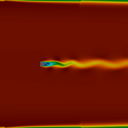

In [8]:
# Folder path/directory
folderDir = "Post-Processing\images\DataBase"

# Image name
imagesPath = folderDir + "\Reynolds300\Reynolds300.0010.png"

# Opening the image
newsize = (128, 128)
img = Image.open(imagesPath).resize(newsize)

# Showing the image
img

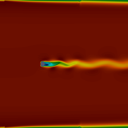

In [9]:
# Image name
imagesPath2 = folderDir + "\Reynolds300\ExtraForComparison\Reynolds300.0020.png"

# Opening the image
newsize = (128, 128)
img2 = Image.open(imagesPath2).resize(newsize)

# Showing the image
img2

In [10]:
def imageLoadGrey(image):
    "Converts an image to greyscale and return an array about it"
    return np.array(image.convert("L"))

def imageLoad(image):
    "Converts an image to an array and return it"
    return np.array(image)

def imageNormalization(image, plot = False, Norm = False):
        "Normalize a grayscales a image"
        _min = np.amin(image)
        _max = np.amax(image)

        norm = 255.0
        if Norm:
            norm = 1.0
            imageNorm = norm * (image - _min) / (_max - _min)
            imageNorm = np.float64(imageNorm)
        else:
            imageNorm = norm * (image - _min) / (_max - _min)
            imageNorm = np.uint8(imageNorm)

        if plot:
            plt.imshow(imageNorm)
            plt.axis("off")
            plt.show()

        return imageNorm

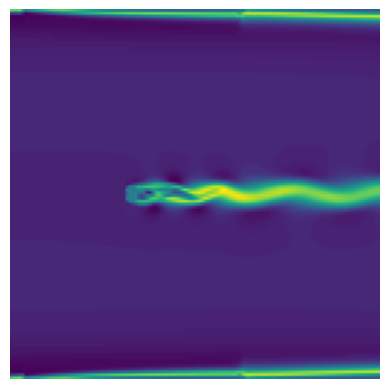

array([[0.76351351, 0.77027027, 0.77702703, ..., 0.29054054, 0.29054054,
        0.29054054],
       [0.16891892, 0.18243243, 0.18918919, ..., 0.54054054, 0.52702703,
        0.52027027],
       [0.00675676, 0.        , 0.        , ..., 0.90540541, 0.90540541,
        0.90540541],
       ...,
       [0.01351351, 0.00675676, 0.        , ..., 0.90540541, 0.90540541,
        0.90540541],
       [0.14189189, 0.17567568, 0.18243243, ..., 0.54054054, 0.52702703,
        0.51351351],
       [0.71621622, 0.76351351, 0.77702703, ..., 0.29054054, 0.29054054,
        0.28378378]])

In [11]:
imageNormalization(img.convert("L"), True, True)

In [12]:
# 3d array to hold the data
ImagesReynolds3D = []
ImagesReynolds3DNormal = []
ImagesReynolds3DGrey = []
# iterate over folders
labels = []
Reynolds = 200
MaxReynolds = 300
while(Reynolds <= MaxReynolds):
    # appending the Reynolds numbers as labels into the array label 
    holder = []
    holder.append(Reynolds/MaxReynolds)
    labels.append(holder)
    # 2d array of size 10 to hold the images per reynolds number
    ImagesReynolds = []
    ImagesReynoldsNormal = []
    ImagesReynoldsGrey = []
    # importing and resizing to 128x128, all images from folder
    for filename in glob.glob(folderDir + "\Reynolds" + str(Reynolds) + "/*.png"):
        # opening the images and resizing them
        imageResized = Image.open(filename).resize(newsize)
        # Appending an image to the 2d list
        ImagesReynolds.append(imageLoad(imageResized))
        ImagesReynoldsGrey.append(imageLoadGrey(imageResized))
        ImagesReynoldsNormal.append(imageNormalization(imageResized.convert("L"), Norm = True))
    # Appending the 2d image list to the 3d list of size 10
    ImagesReynolds3D.append(ImagesReynolds)
    ImagesReynolds3DGrey.append(ImagesReynoldsGrey)
    ImagesReynolds3DNormal.append(ImagesReynoldsNormal)
    #Increasing the Reynolds number
    Reynolds = Reynolds + 10
#ImagesReynolds3D

In [13]:
# 3d array to hold the data
Reynolds = 200
ImagesReynolds3DTarget = []
ImagesReynolds3DNormalTarget = []
ImagesReynolds3DGreyTarget = []
# iterate over folders
while(Reynolds <= MaxReynolds):
    # 2d array of size of temporal serie to hold the images per reynolds number
    ImagesReynoldsTarget = []
    ImagesReynoldsNormalTarget = []
    ImagesReynoldsGreyTarget = []
    # importing and resizing to 128x128, for one image from the folders
    filename = folderDir + "\Reynolds" + str(Reynolds) + "\ExtraForComparison\Reynolds" + str(Reynolds) + ".0011.png"
    # opening the image and resizing it
    imageResizedTarget = Image.open(filename).resize(newsize)
    # Appending an image to the 2d list
    ImagesReynoldsTarget.append(imageLoad(imageResizedTarget))
    ImagesReynoldsGreyTarget.append(imageLoadGrey(imageResizedTarget))
    ImagesReynoldsNormalTarget.append(imageNormalization(imageResizedTarget.convert("L"), Norm = True))
    # Appending the 2d image list to the 3d list of size of the temporal serie
    ImagesReynolds3DTarget.append(ImagesReynoldsTarget)
    ImagesReynolds3DGreyTarget.append(ImagesReynoldsGreyTarget)
    ImagesReynolds3DNormalTarget.append(ImagesReynoldsNormalTarget)
    #Increasing the Reynolds number
    Reynolds = Reynolds + 10
#ImagesReynolds3D

In [14]:
ImagesReynolds3DTarget = np.array(ImagesReynolds3DTarget)
ImagesReynolds3DTarget.shape

(11, 1, 128, 128, 3)

In [15]:
ImagesReynolds3DNormalTarget = np.array(ImagesReynolds3DNormalTarget)
ImagesReynolds3DNormalTarget.shape

(11, 1, 128, 128)

In [16]:
ImagesReynolds3DGreyTarget = np.array(ImagesReynolds3DGreyTarget)
ImagesReynolds3DGreyTarget.shape

(11, 1, 128, 128)

In [17]:
ImagesReynolds3D = np.array(ImagesReynolds3D)
ImagesReynolds3D.shape

(11, 11, 128, 128, 3)

In [18]:
ImagesReynolds3DNormal = np.array(ImagesReynolds3DNormal)
ImagesReynolds3DNormal.shape

(11, 11, 128, 128)

In [19]:
ImagesReynolds3DGrey = np.array(ImagesReynolds3DGrey)
ImagesReynolds3DGrey.shape

(11, 11, 128, 128)

In [20]:
input_shape = ImagesReynolds3DNormal.shape[1:]
input_shape

(11, 128, 128)

In [21]:
labels = np.array(labels)
print(labels)
labels.shape

[[0.66666667]
 [0.7       ]
 [0.73333333]
 [0.76666667]
 [0.8       ]
 [0.83333333]
 [0.86666667]
 [0.9       ]
 [0.93333333]
 [0.96666667]
 [1.        ]]


(11, 1)

In [22]:
from sklearn.model_selection import train_test_split

data = ImagesReynolds3DNormal
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.20, random_state=78)

# Convert labels vertices to binary class matirces
labels_train = keras.utils.to_categorical(labels_train, labels.size)
labels_test = keras.utils.to_categorical(labels_test, labels.size)

In [23]:
labels_train.shape

(8, 11)

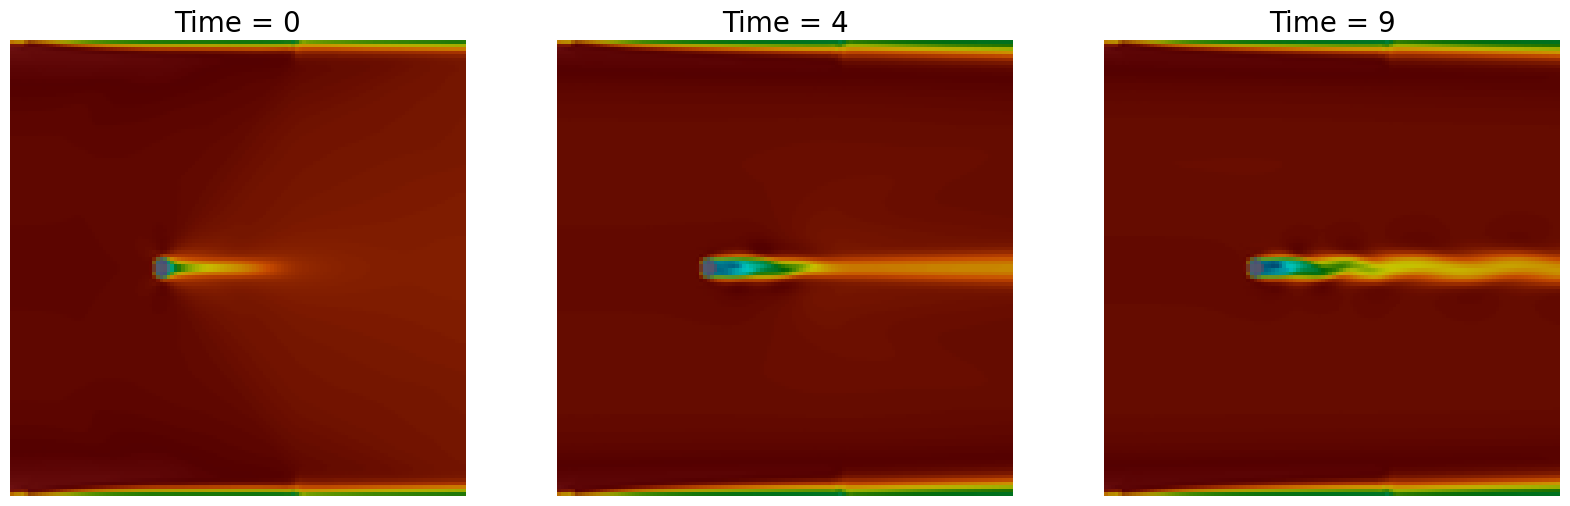

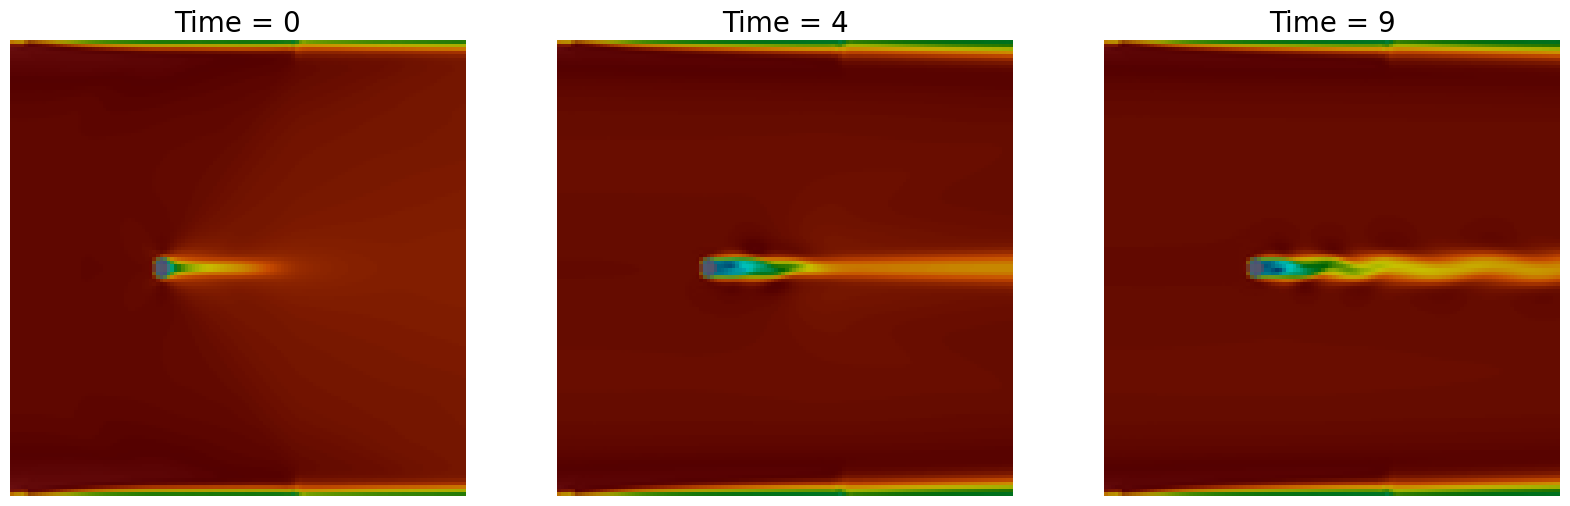

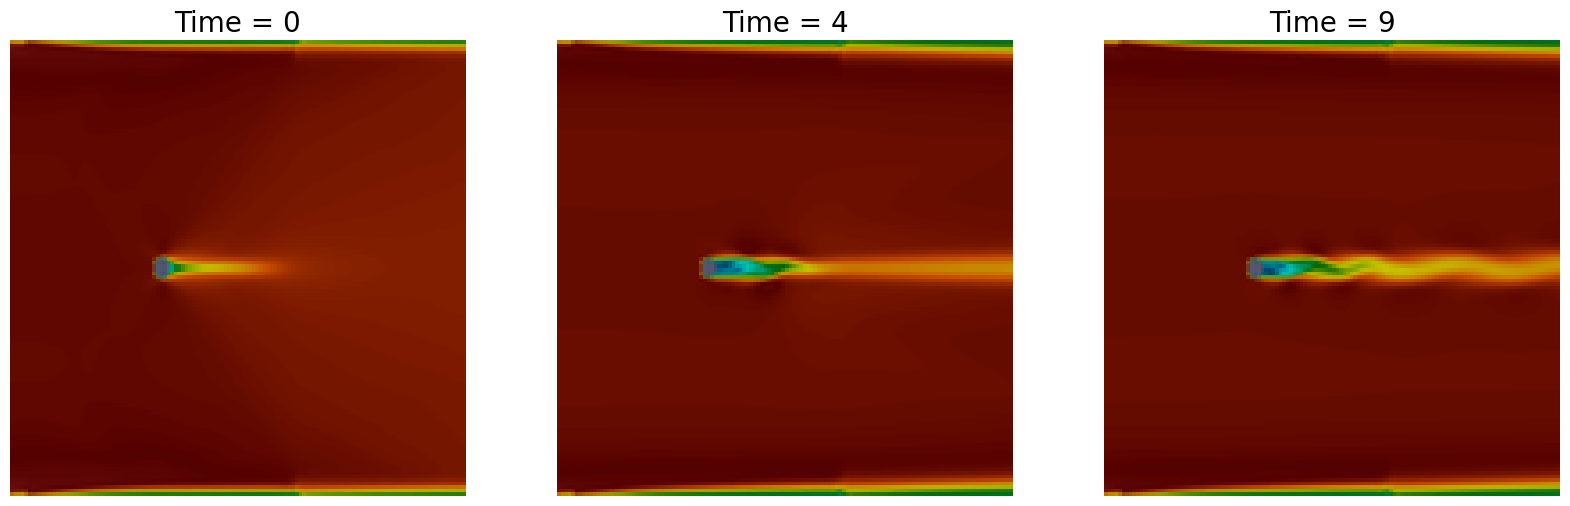

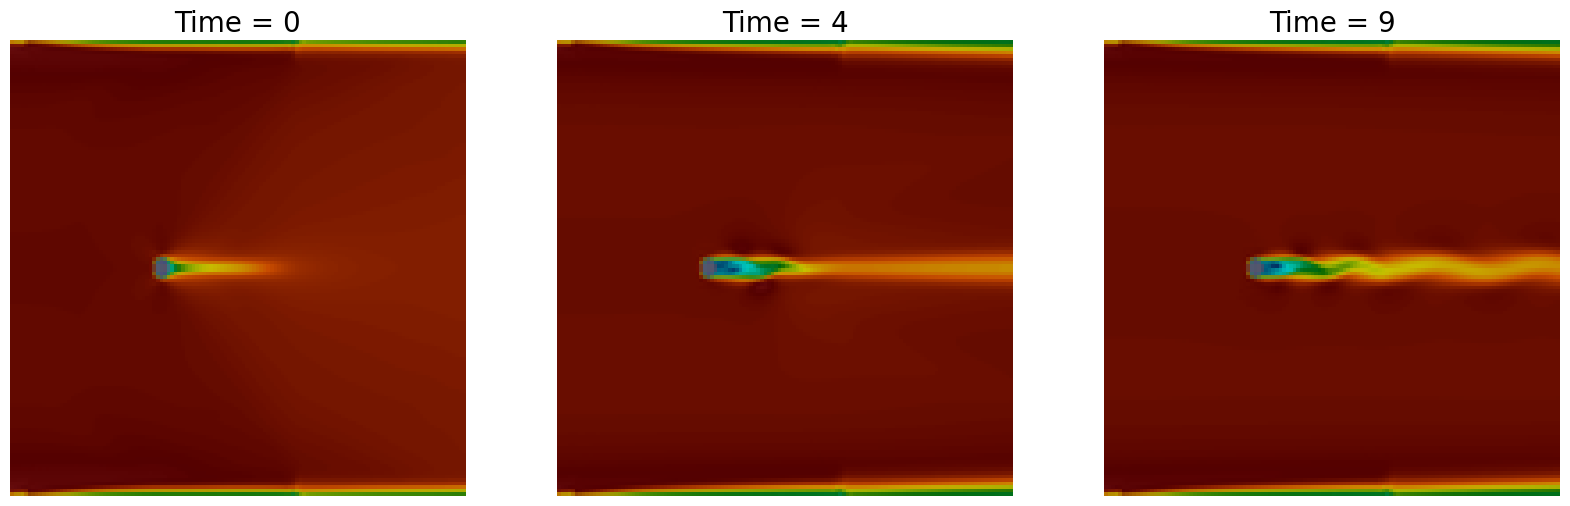

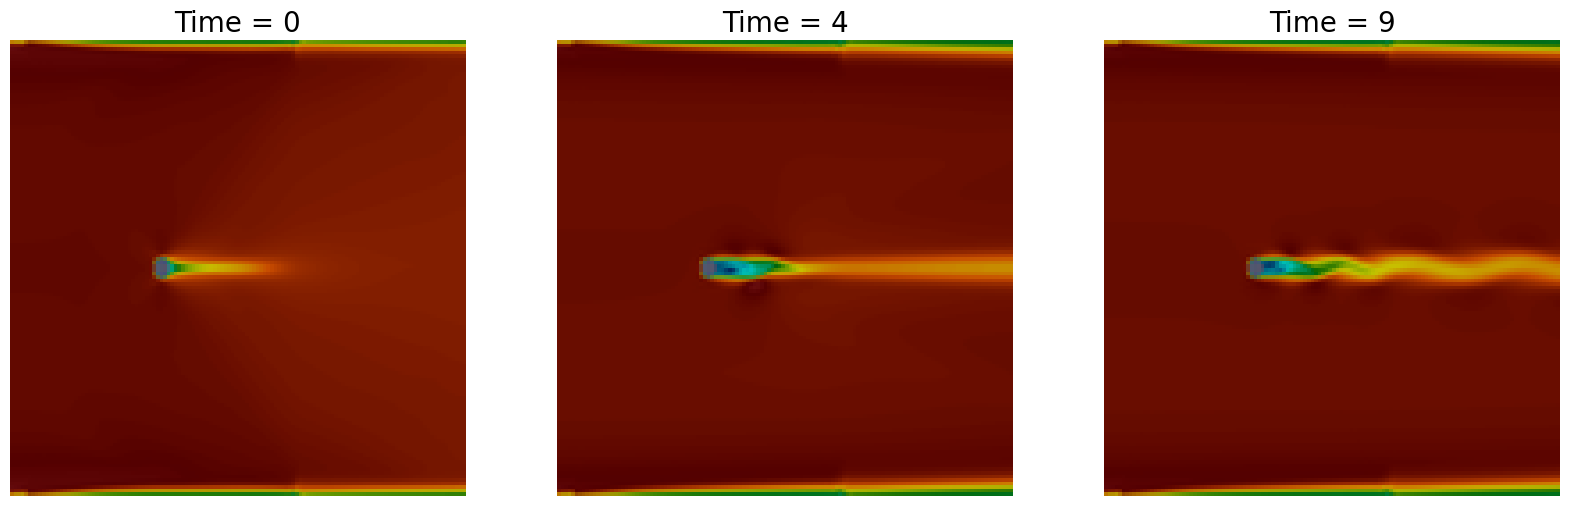

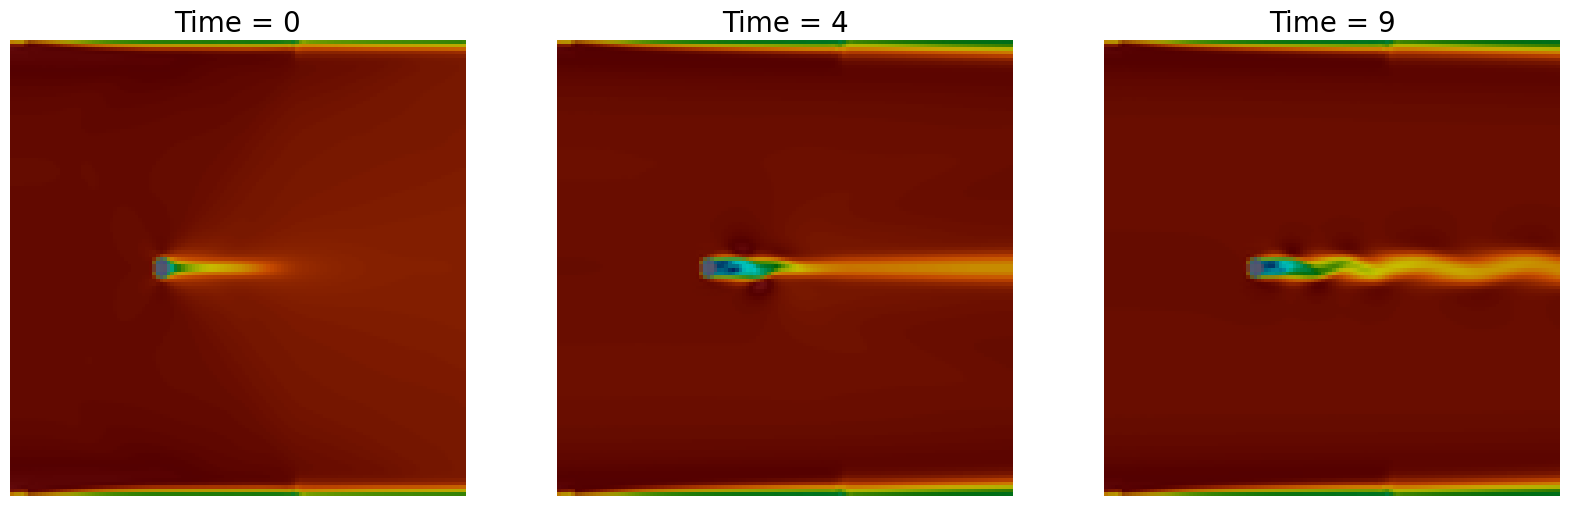

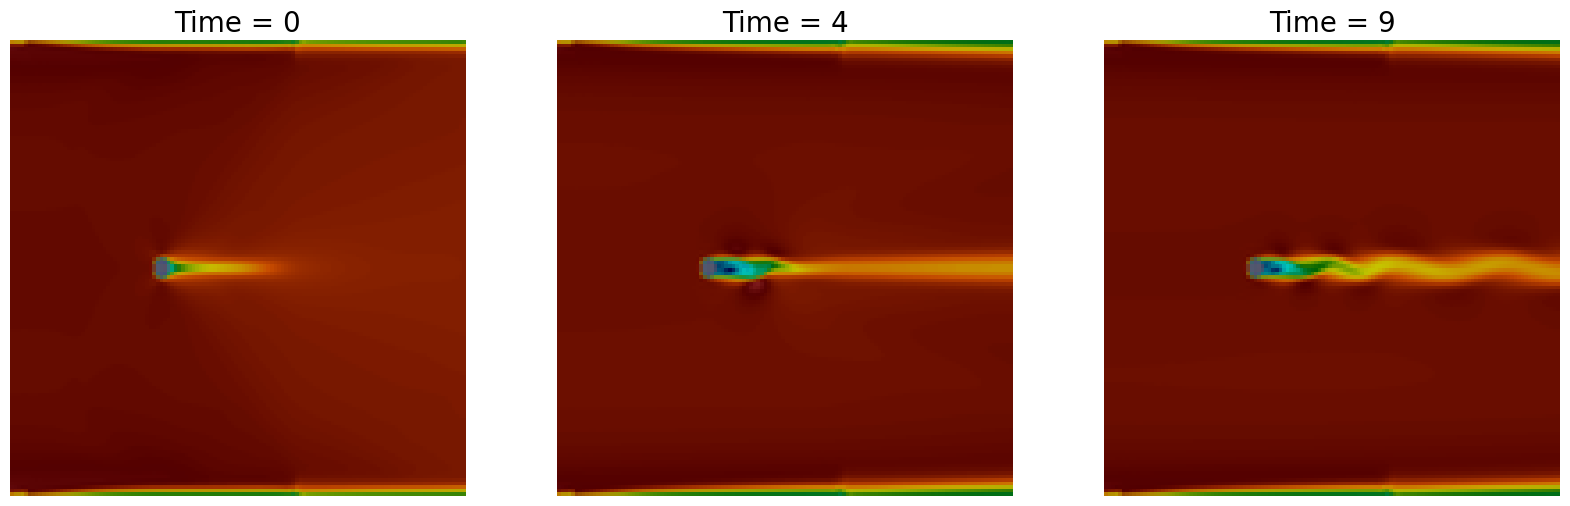

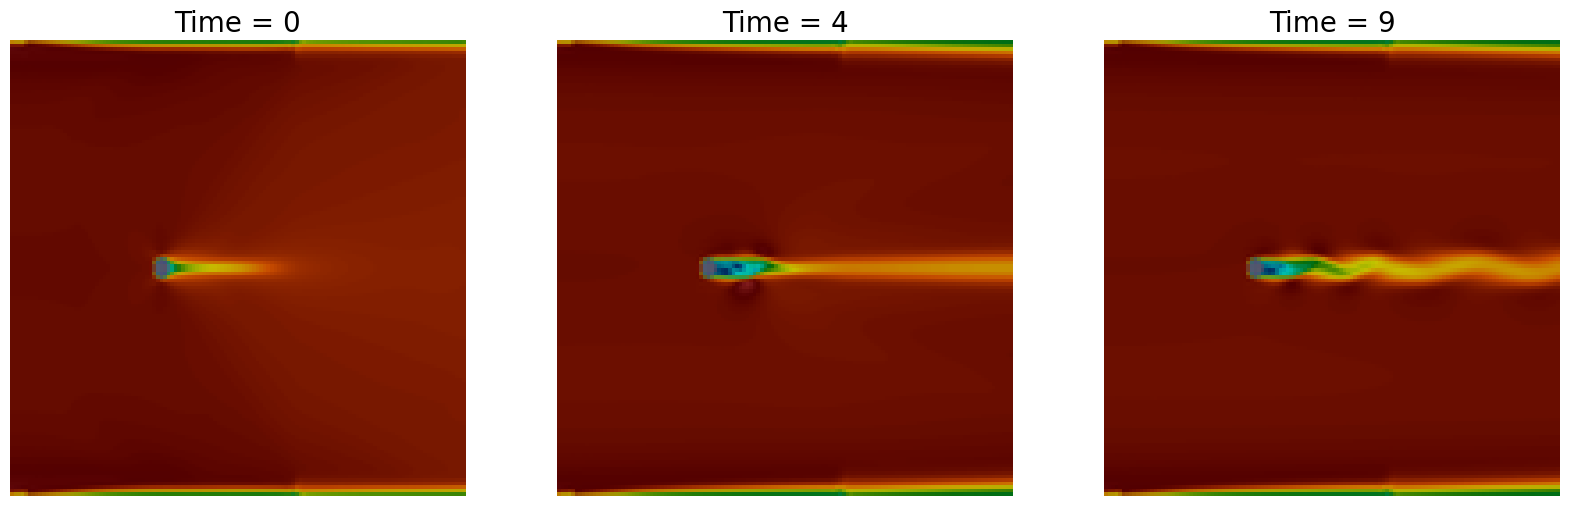

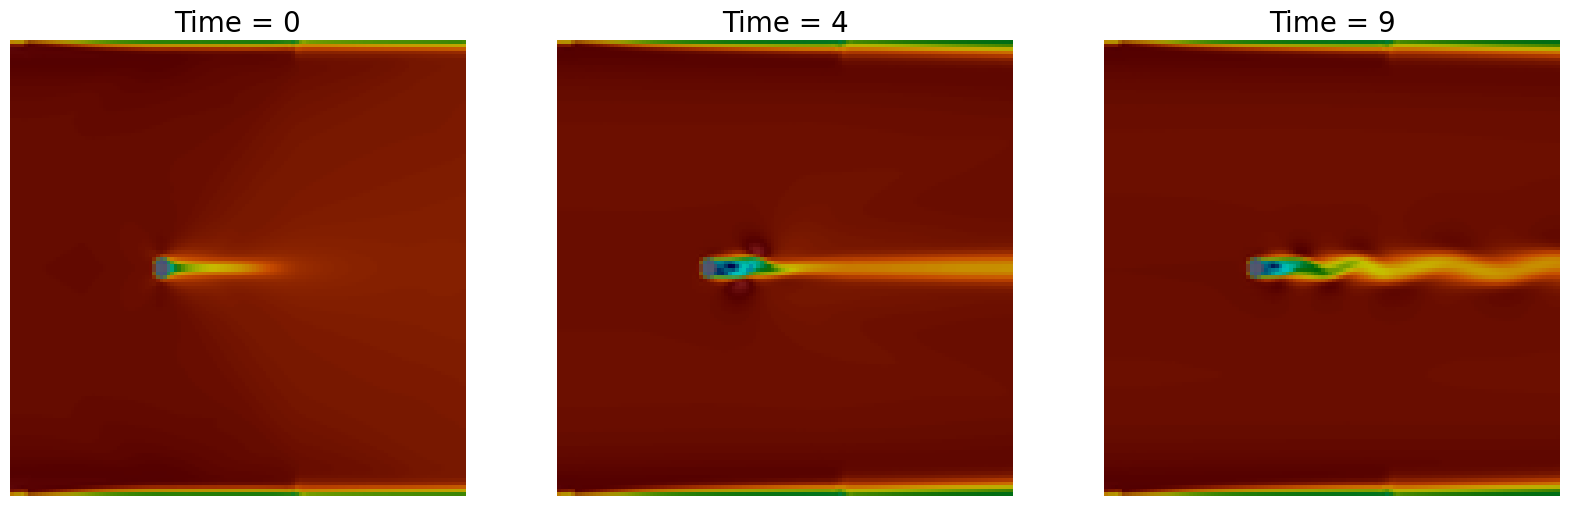

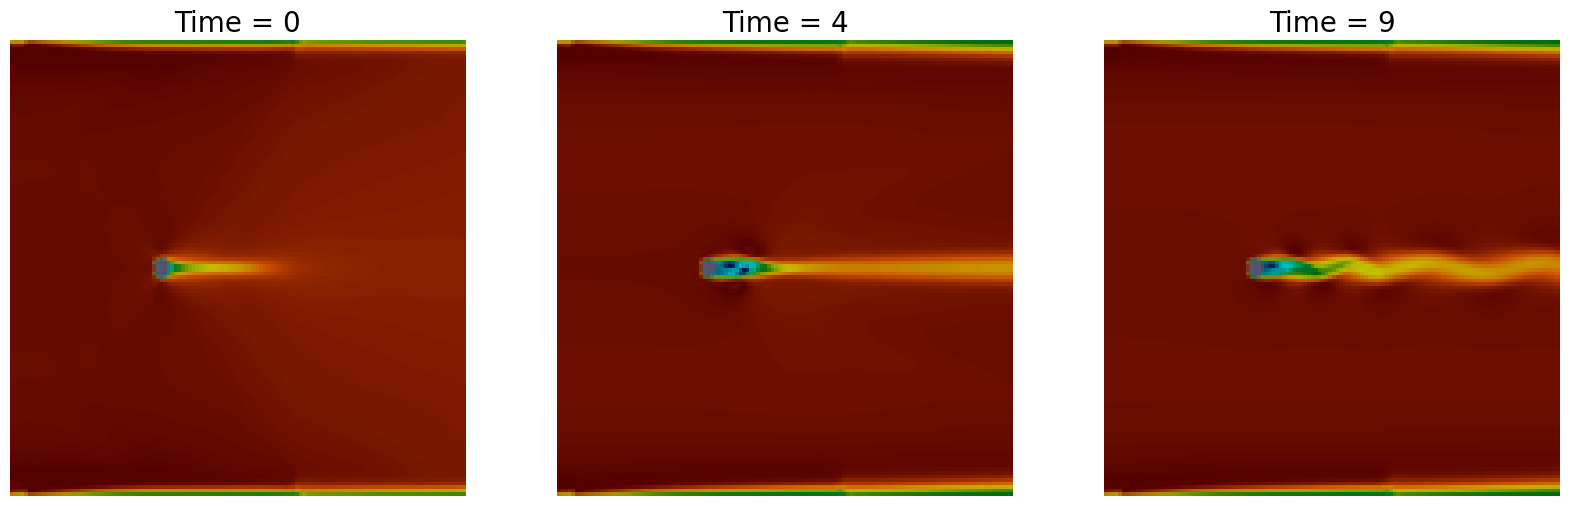

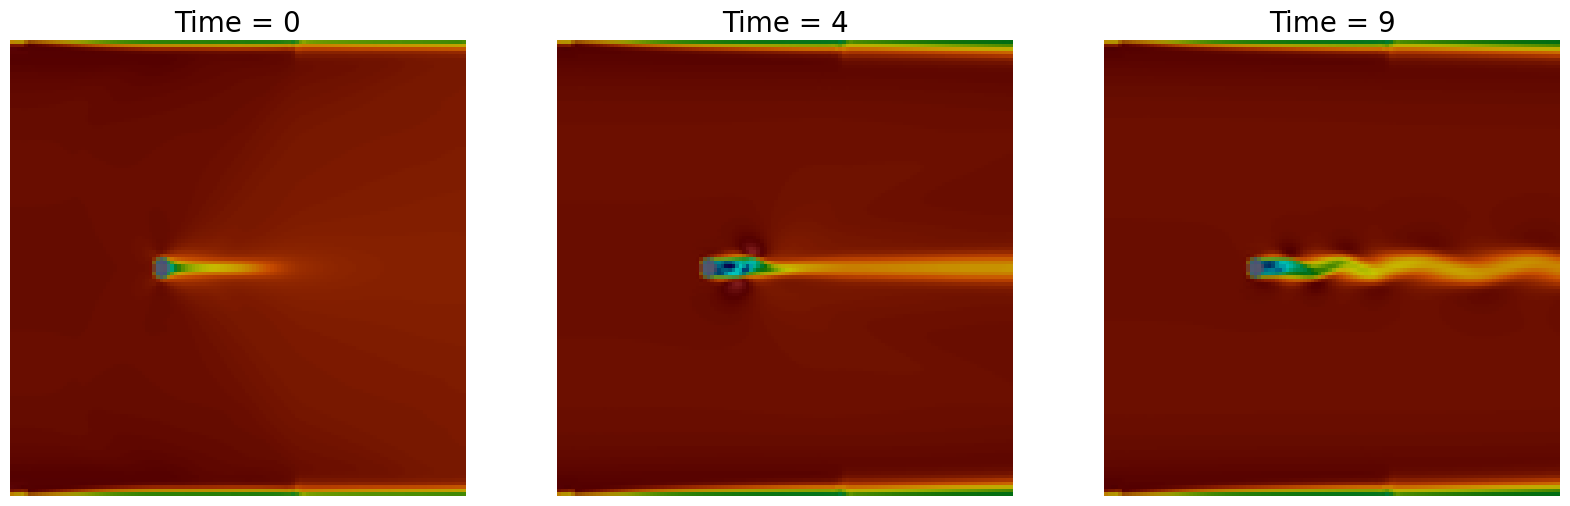

In [24]:
# Plotting imagem from every example
# Config for the sizes of the boxes to be ploted
boxSizeX = 20
boxSizeY = 10
fontsize = 20
# Looping through all Reynolds numbers
for ReynoldsNumber in range(len(ImagesReynolds3D)):
    # Setting the boxes sizes
    plt.figure(figsize=[boxSizeX,boxSizeY])
    # Looping throuhg all times
    i = 1
    for time in range(len(ImagesReynolds3D[ReynoldsNumber])):
        if time == 0 or time == 4 or time == 9:
        # Subplotting every box with 11 timesteps for one example
            plt.subplot(1, 3, i)
            i = i + 1
            # Looping to open every image 
            for image in ImagesReynolds3D[ReynoldsNumber][time]:
                plt.axis('off')
                # Showing every image stored in the array
                plt.imshow(ImagesReynolds3D[ReynoldsNumber][time], cmap=plt.cm.gray, interpolation='nearest')
                # Plotting its images' time step 
                plt.title('Time = %d'%int(time), fontdict={'fontsize': fontsize})
    plt.show()


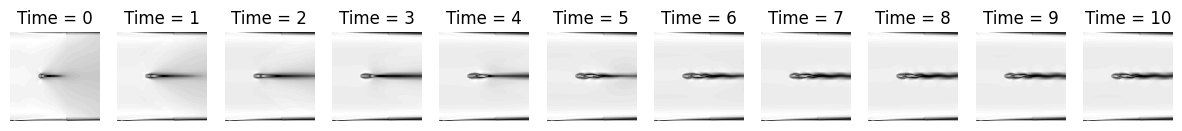

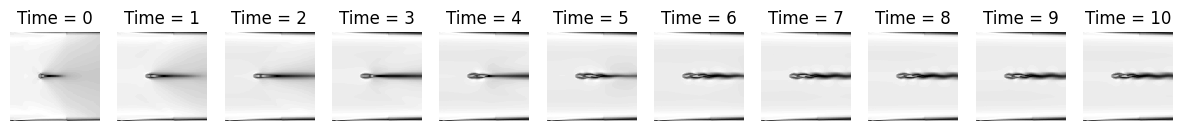

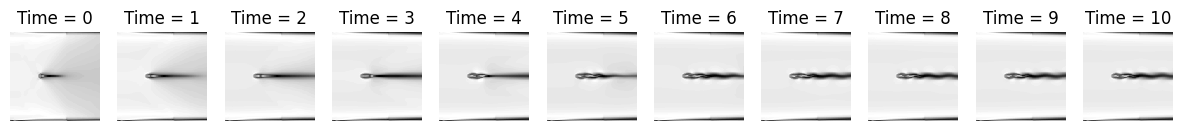

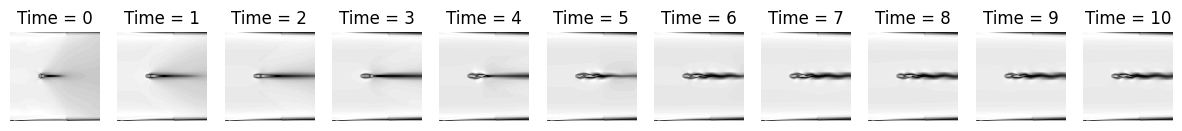

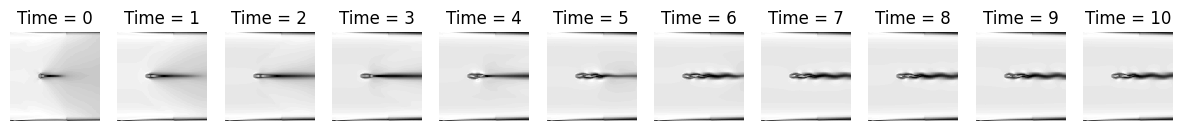

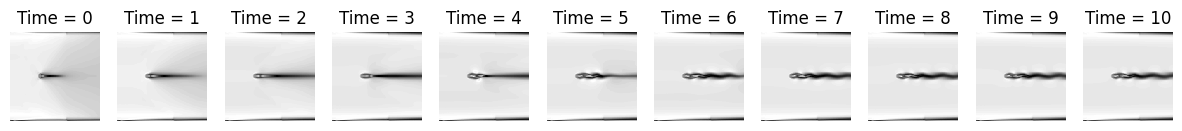

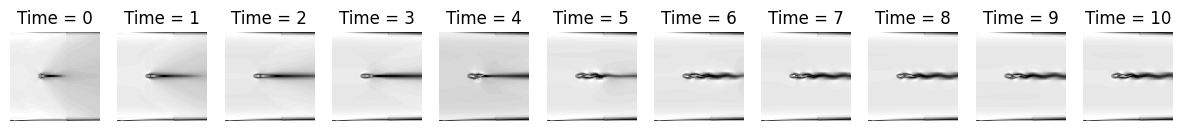

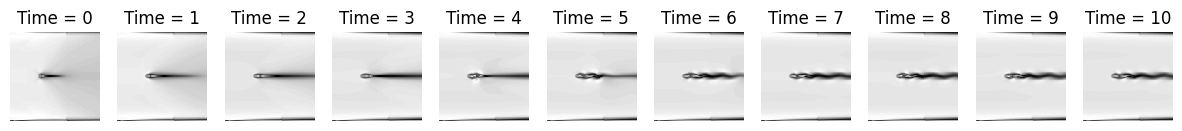

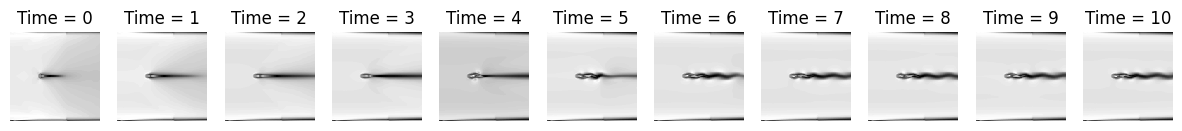

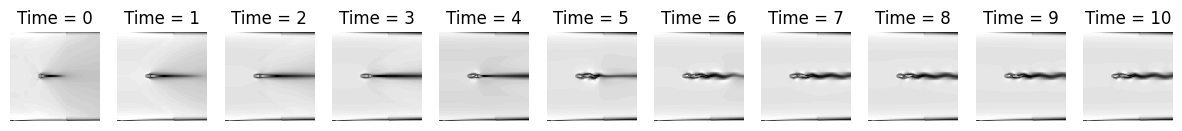

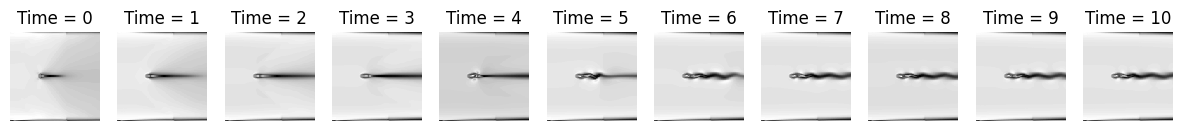

In [25]:
# Plotting imagem from every example
# Config for the sizes of the boxes to be ploted
boxSizeX = 15
boxSizeY = 11
# Looping through all Reynolds numbers
for ReynoldsNumber in range(len(ImagesReynolds3DGrey)):
    # Setting the boxes sizes
    plt.figure(figsize=[boxSizeX,boxSizeY])
    # Looping throuhg all times 
    for time in range(len(ImagesReynolds3DGrey[ReynoldsNumber])):
        # Subplotting every box with 11 timesteps for one example
        plt.subplot(1, 11, time + 1)
        # Looping to open every image 
        for image in ImagesReynolds3DGrey[ReynoldsNumber][time]:
            # if time == 0 or time == 4 or time == 9:
            plt.axis('off')
            # Showing every image stored in the array
            plt.imshow(ImagesReynolds3DGrey[ReynoldsNumber][time], cmap=plt.cm.gray_r, interpolation='nearest')
            # Plotting its images' time step 
            plt.title('Time = %d'%int(time))
    plt.show()

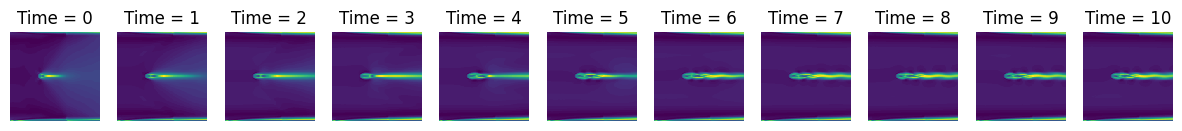

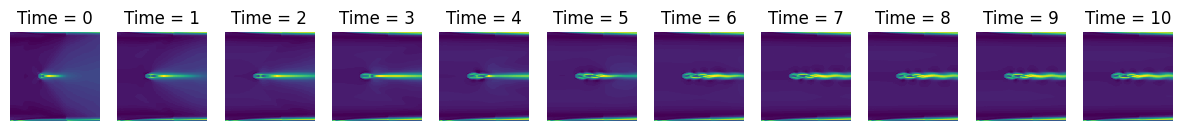

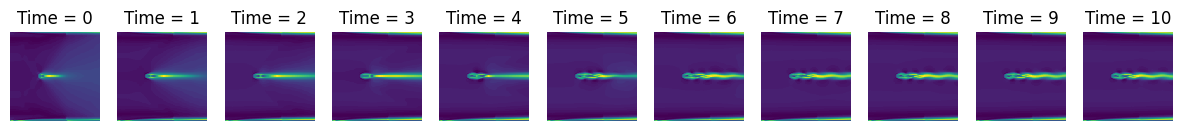

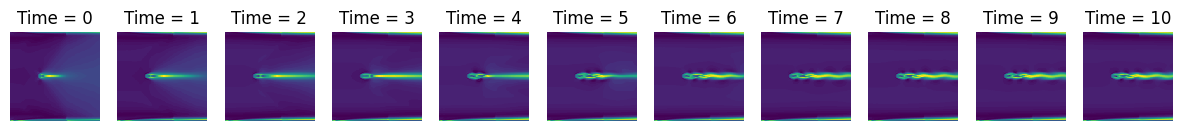

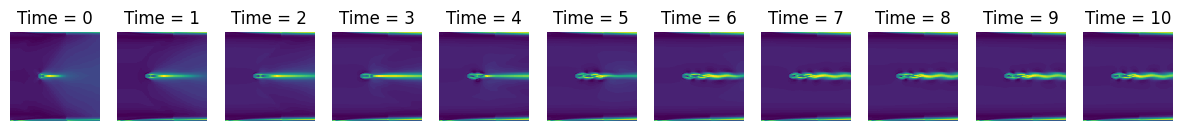

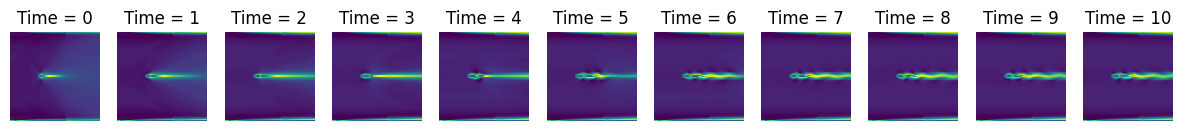

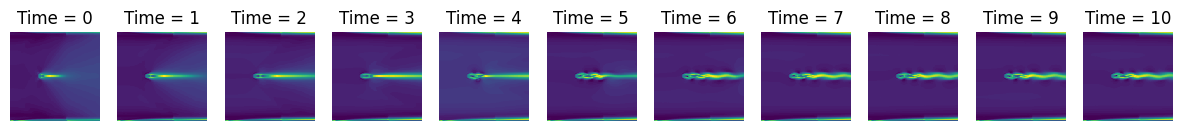

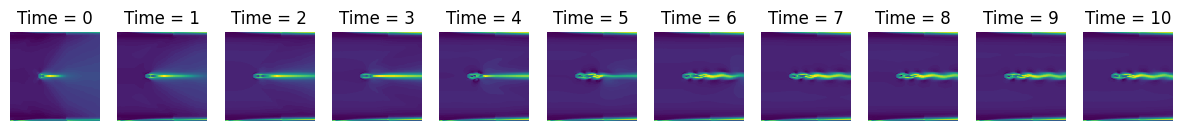

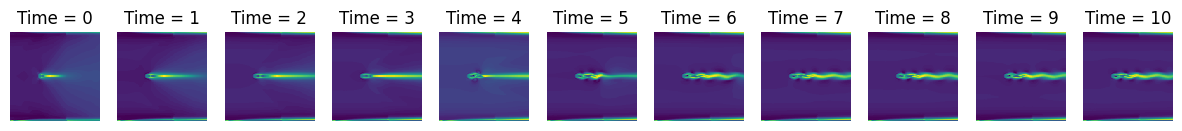

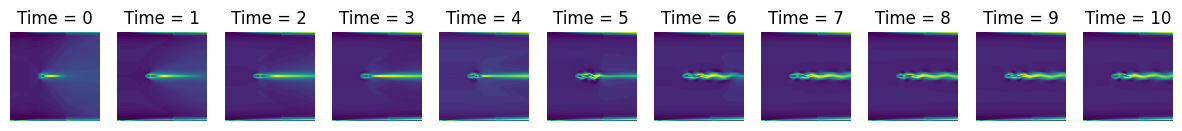

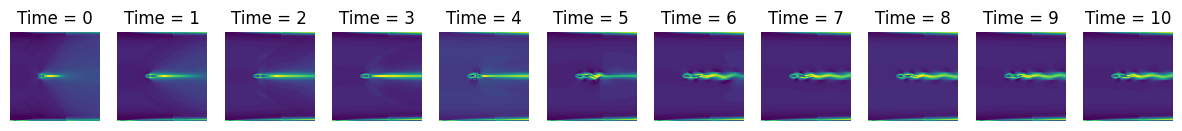

In [26]:
# Plotting imagem from every example
# Config for the sizes of the boxes to be ploted
boxSizeX = 15
boxSizeY = 11
# Looping through all Reynolds numbers
for ReynoldsNumber in range(len(ImagesReynolds3DNormal)):
    # Setting the boxes sizes
    plt.figure(figsize=[boxSizeX,boxSizeY])
    # Looping throuhg all times 
    for time in range(len(ImagesReynolds3DNormal[ReynoldsNumber])):
        # Subplotting every box with 11 timesteps for one example
        plt.subplot(1, 11, time + 1)
        # Looping to open every image 
        for image in ImagesReynolds3DNormal[ReynoldsNumber][time]:
            # if time == 0 or time == 4 or time == 9:
            plt.axis('off')
            # Showing every image stored in the array
            plt.imshow(ImagesReynolds3DNormal[ReynoldsNumber][time], interpolation='nearest')
            # Plotting its images' time step 
            plt.title('Time = %d'%int(time))
    plt.show()

In [43]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [45]:
DefaultConv2DTranspose = partial(keras.layers.Conv2DTranspose, kernel_size=3, strides=1, padding="SAME", use_bias=False)

class ResidualUnitTranspose(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2DTranspose(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2DTranspose(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2DTranspose(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [28]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(min_delta = 0.001, patience = 10, restore_best_weights=True)

In [85]:
keras.backend.clear_session()
tf.random.set_seed(99)
np.random.seed(99)

model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[128, 128, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
# model.add(keras.layers.MaxPool2D(pool_size=3, strides=1, padding="SAME"))

filters = 128
i = 0
while i < 3:
    model.add(ResidualUnit(filters, strides=2))
    model.add(ResidualUnit(filters, strides=1))
    # model.add(keras.layers.Dropout(rate=0.5))
    filters = 2*filters
    i = i + 1

filters = filters/2

j = 0
while j < 3:
    filters = filters/2
    model.add(ResidualUnitTranspose(filters, strides=2))
    model.add(ResidualUnitTranspose(filters, strides=1))
    # model.add(keras.layers.Dropout(rate=0.5))
    j = j + 1

model.add(DefaultConv2DTranspose(3, kernel_size=7, strides=2))
# model.add(keras.layers.GlobalAvgPool2D())
# model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(128, activation="softmax"))

In [86]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        9408      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 64)        0         
                                                                 
 residual_unit (ResidualUnit  (None, 32, 32, 128)      230912    
 )                                                               
                                                                 
 residual_unit_1 (ResidualUn  (None, 32, 32, 128)      295936    
 it)                                                             
                                                        

In [87]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [91]:
history = model.fit(ImagesReynolds3D[0], ImagesReynolds3DTarget[0], epochs=100, callbacks=[early_stopping])

ValueError: Data cardinality is ambiguous:
  x sizes: 11
  y sizes: 1
Make sure all arrays contain the same number of samples.

In [ ]:
model.evaluate(#x_test, #y_test)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="sparse-categorical-entropy")
history_df.loc[:, ['sparse_categorical_accuracy', 'val_accuracy']].plot(title="Accuracy")